<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Reading-and-Exploring-the-Data" data-toc-modified-id="Reading-and-Exploring-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading and Exploring the Data</a></span><ul class="toc-item"><li><span><a href="#Numerical-Features-Analysis" data-toc-modified-id="Numerical-Features-Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Numerical Features Analysis</a></span></li><li><span><a href="#Categorical-Features-Analysis" data-toc-modified-id="Categorical-Features-Analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Categorical Features Analysis</a></span></li><li><span><a href="#Insights-from-Data" data-toc-modified-id="Insights-from-Data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Insights from Data</a></span></li></ul></li></ul></div>

First kernel warning!

Hi everyone! The _German Credit Risk_ dataset has been the first place I started my kaggle journey. As long as I've been studying Data Science and Machine Learning, I always saw Kaggle as one of the greates ways to learn more about everything related on these two topics. So here I am!

_Edit: after learned a lot, I returned to this notebook to update something and share with you good stuff. I really hope you like it and, if you do, please **upvote** and visit my other notebooks._

# Libraries

In [1]:
# Stsandard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time

# Utilities
from utils.viz_utils import *
from utils.ml_utils import *
from utils.custom_transformers import *

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, \
                                    learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
    accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Reading and Exploring the Data

Here we will answear the following questions:
    - What's the content of data?
    - How are the numerical attributes distributed?
    - How are the categorical attributes distributed?
    - What's the influence of Risk and Credit Amount in other features?
    - Is there any other pattern that may be related to credit risk?

In [2]:
# Data path
df_ori = import_data('../data/german_credit_data.csv', optimized=True)
df = df_ori.iloc[:, 1:]
df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]

# Results
print(f'Data dimension: {df.shape}')
df.head()

O dataset possui 11 colunas, das quais 5 são elegíveis a otimização.

----------------------------------------------------
Memória RAM utilizada (50 linhas): 0.0043 MB
Memória RAM após otimização (50 linhas): 0.0033 MB
----------------------------------------------------

Ganho de 77.68% em uso de memória!

Data dimension: (1000, 10)


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


___
* _Target class balance_
___

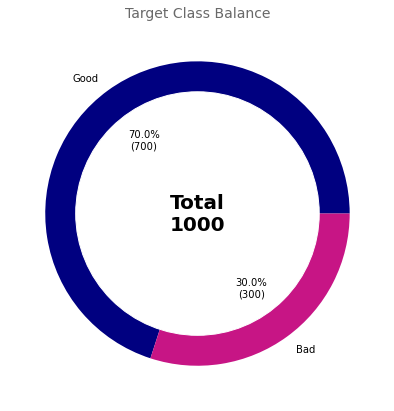

In [3]:
# Target class balance
fig, ax = plt.subplots(figsize=(7, 7))
label_names = ['Good', 'Bad']
color_list = ['navy', 'mediumvioletred']
text = f'Total\n{len(df_ori)}'
title = 'Target Class Balance'

# Visualizing it through a donut chart
donut_plot(df, col='risk', ax=ax, label_names=label_names, colors=color_list, title=title, text=text)

In [4]:
# Overview from the data
df_overview = data_overview(df)
df_overview

,feature,qtd_null,percent_null,dtype,qtd_cat
0,checking_account,394,0.394,object,3
1,saving_accounts,183,0.183,object,4
2,age,0,0.000,int32,0
3,sex,0,0.000,object,2
4,job,0,0.000,int32,0
5,housing,0,0.000,object,3
6,credit_amount,0,0.000,int32,0
7,duration,0,0.000,int32,0
8,purpose,0,0.000,object,8
9,risk,0,0.000,object,2


## Numerical Features Analysis

___
* _Distribution_
___

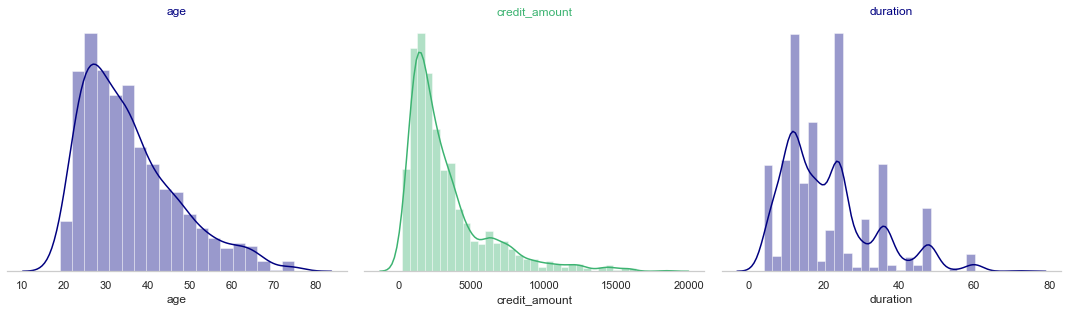

In [5]:
num_cols = ['age', 'credit_amount', 'duration']
color_sequence = ['navy', 'mediumseagreen', 'navy']
numplot_analysis(df[num_cols], color_sequence=color_sequence, hist=True)
plt.show()

___
* _Distribution by risk_
___

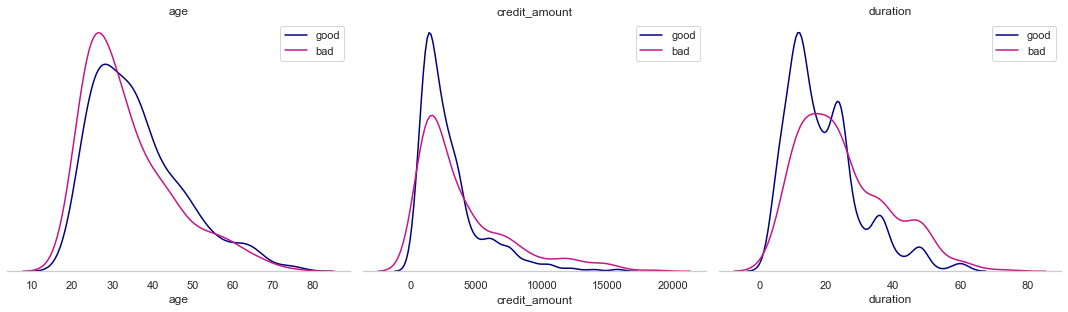

In [6]:
num_cols += ['risk']
numplot_analysis(df[num_cols], hue='risk', color_hue=color_list)

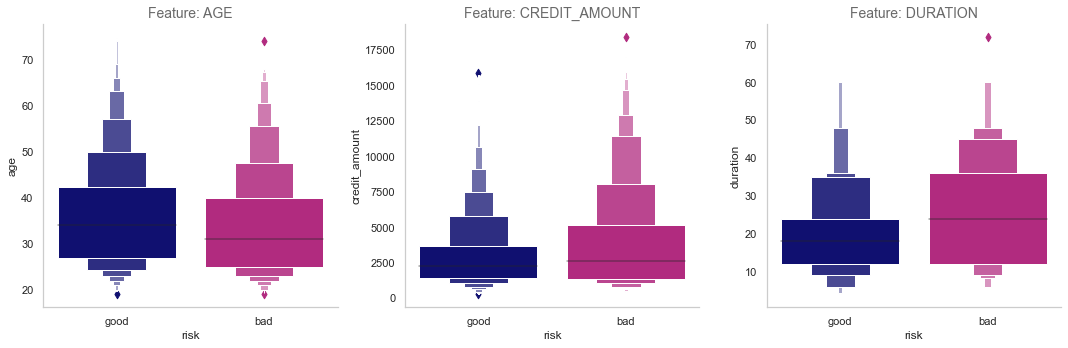

In [19]:
boxenplot(df, features=['age', 'credit_amount', 'duration'], hue='risk', fig_cols=3, figsize=(15, 5), 
          palette=color_list)

By looking at the the plots above, it's reasonble to point that:

* **Young people tend to present more risk than the older ones**
    * To me this statement makes sense because maybe older people usually have more financial stability than the younger ones;
    * By the perspective of a bank or a loan establishment, probably it's safer to offer better credit programs to people who has condition to pay back.
    
    
* **Higher credit amount presents more risk than lower ones**
    * Well, this is kind of intuitive and makes total sense to me;
    * By the perspective of a customer who took a loan or entered a credit program, it's easier to pay back a low amount.
    
    
* **Higher duration is related to a higher risk**
    * Once again this is perfectly fine to say;
    * The common credit programs are based on interest or fees that gets higher through the time;
    * A costumer who took money for a long time will have to pay much more by the end.

## Categorical Features Analysis

___
* _Quantity for each category_
___

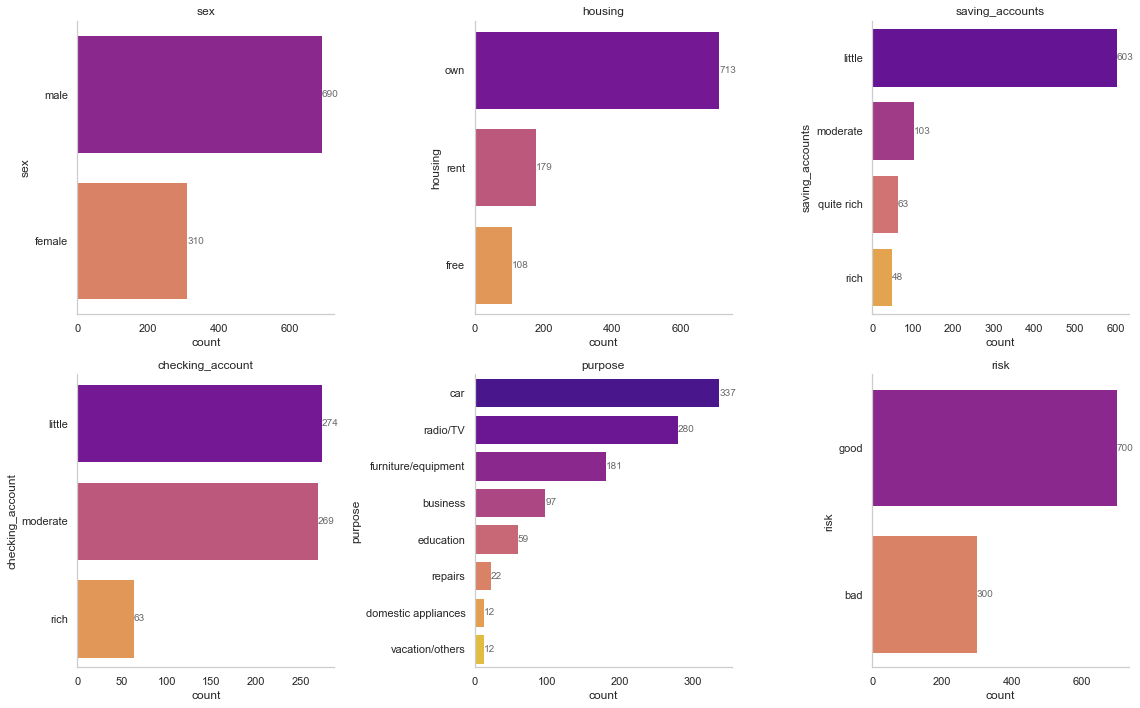

In [7]:
cat_features = [col for col, dtype in df.dtypes.items() if dtype == 'object']
catplot_analysis(df[cat_features], palette='plasma')

These categorical analysis provided an overview of our dataset in terms of quantity. For each categorical column, now is possible to know what are the marjority ones. Meanwhile, to give more power to the analysis, let's separate each categorical entry into the risk approach.

___
* _Quantity for each category by risk_
___

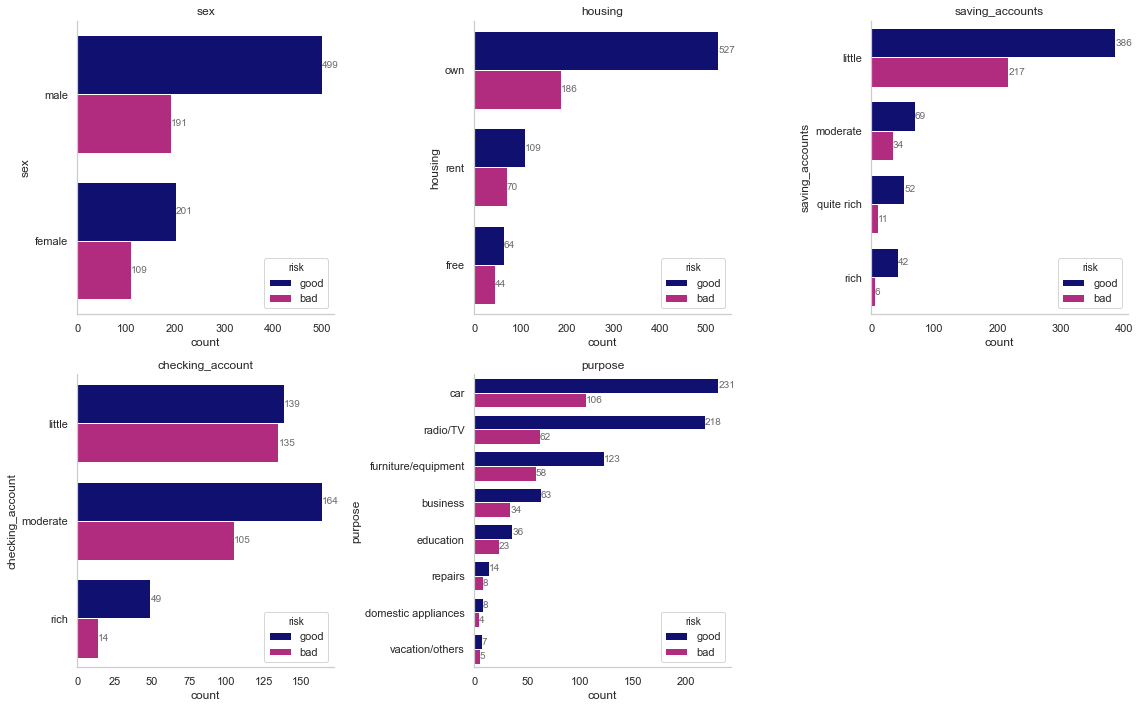

In [8]:
catplot_analysis(df[cat_features], hue='risk', palette=color_list)

On the first look, maybe the main category that demands some attention if `checking_account`. If we look at those ones with _little_ checking account and its distribution by risk, it's almost 50/50. To make it cleaner for us to conclude, let's repeat this analysis but in a percentage approach.

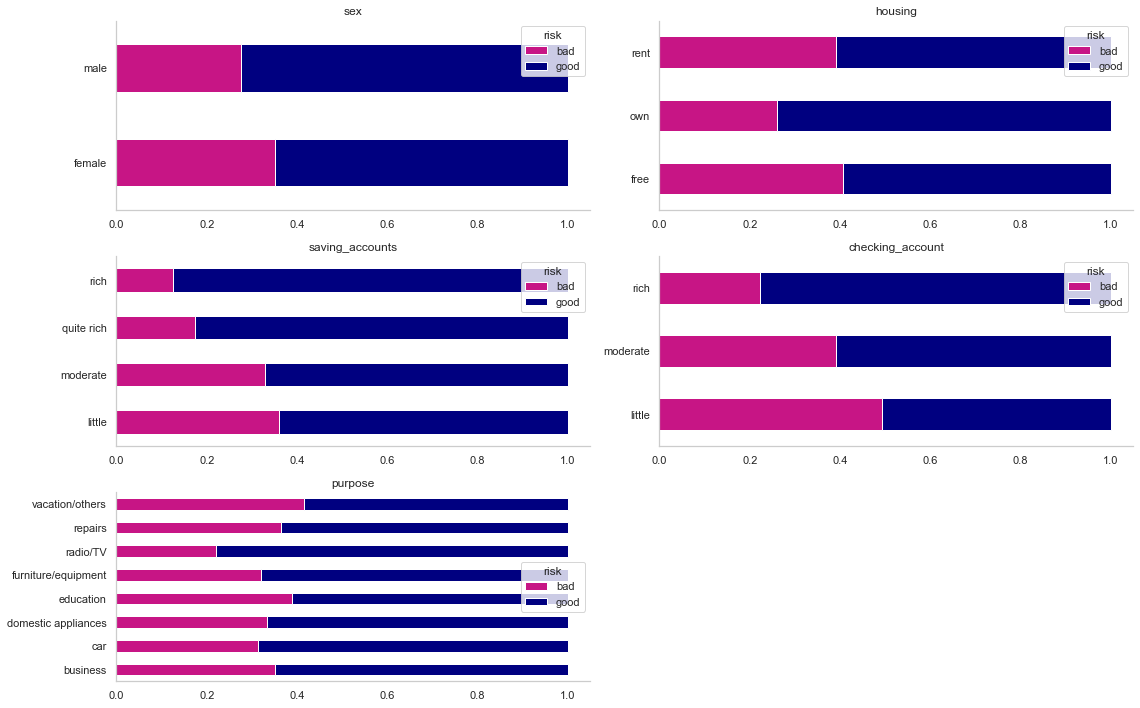

In [9]:
rev_color_list = ['mediumvioletred', 'navy']
catplot_percentage_analysis(df[cat_features], hue='risk', palette=rev_color_list)

The insights we can take from the plot above are:

* People with `little` saving account and checking account presents higher risk;
* When customers take some credit for `vacation/others`, it's a sign that the risk could be high;
* People who have their own house have lower risk

## Insights from Data

In this session we will go deeper into the dataset to make some graphical analysis in order to take valuable insights that could be used on understanding the problem or even on training a model.

___
* _For what purpose people tend to apply for higher amount loans in average? In terms of total amount, what's the main purpose?_
___

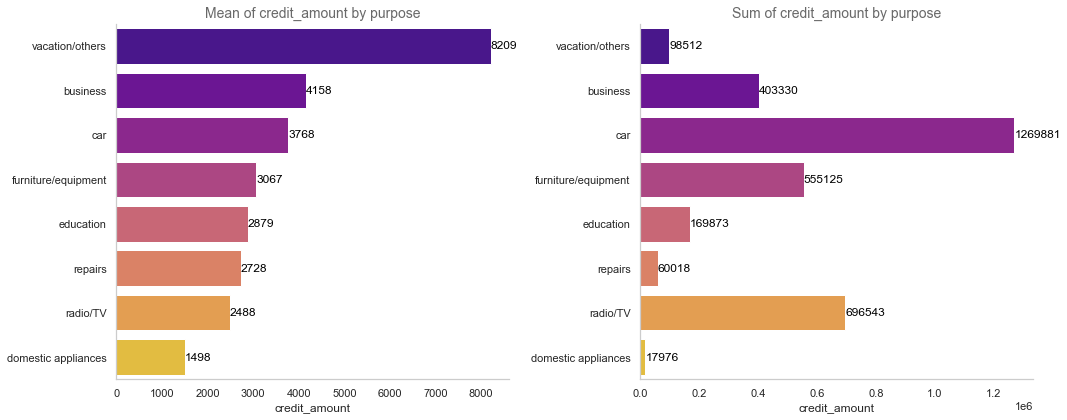

In [10]:
mean_sum_analysis(df, group_col='purpose', value_col='credit_amount')

We could see by the graphic that, in average, people often request higher credit amount for `vacation/other`. Meanwhile this purpose is only the 6th in terms of total amount given by the loan establishment.

By the way, people who request credit for `car` purpose representes the main public for the bank/loan establishment.

___
* _Is there any purpose in particular with long duration credit requests?_
___

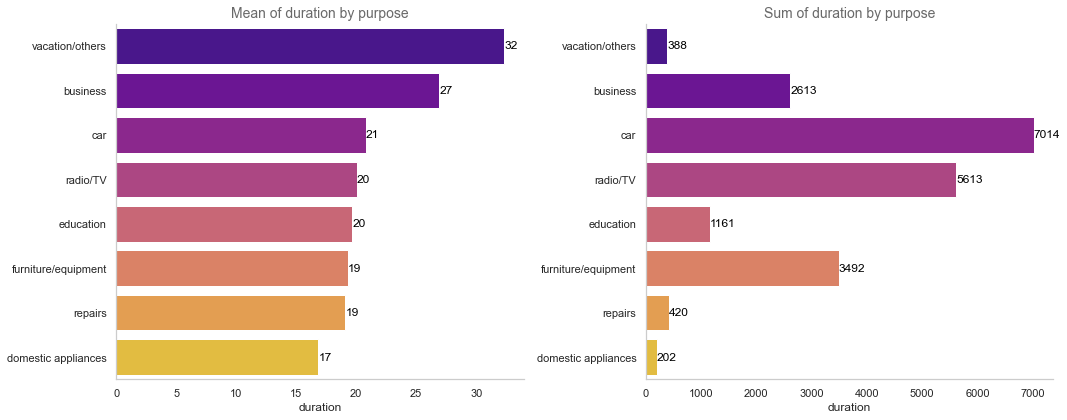

In [11]:
mean_sum_analysis(df, group_col='purpose', value_col='duration')

___
* _How credit amount is related to gender?_
___

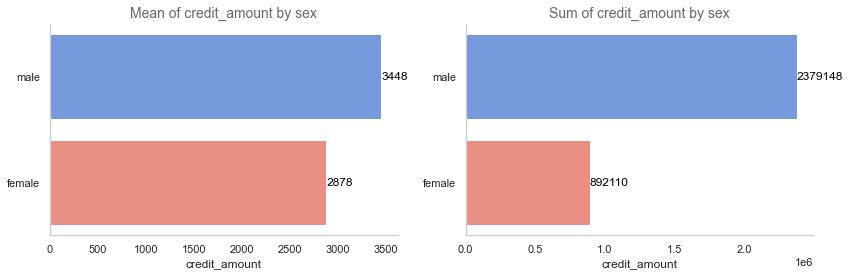

In [12]:
gender_palette = ['cornflowerblue', 'salmon']
mean_sum_analysis(df, group_col='sex', value_col='credit_amount', palette=gender_palette, figsize=(12, 4))

TO DO:

    - Finish the exploratory data analysis;
    - Build and apply a Pipeline for data prep;
    - Train different classifiers to predict the credit risk;
    - Choose the best one based on classifying metrics.

If you like this kernel, please **upvote**!